In [1]:
from torch import nn
import torch
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from src.data.cifar import CIFARData
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

In [2]:
latent_dim = 2
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28*1, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, latent_dim),
)

In [3]:
net_state_dict = torch.load('../models/laplace_model.ckpt', map_location=torch.device('cpu'))

In [4]:
model.load_state_dict(net_state_dict)
H = torch.load('../models/laplace_hessian.ckpt', map_location=torch.device('cpu'))

In [12]:
sigma_q

tensor([5.9785e-05, 6.7315e-05, 7.2419e-05,  ..., 2.4744e-06, 3.3322e-04,
        3.3322e-04])

In [5]:
batch_size = 16
data = CIFARData("../data/", batch_size, 4)
data.setup()
loader = data.val_dataloader()

In [6]:
mu_q = parameters_to_vector(model.parameters())
sigma_q = 1 / (H + 1e-6)

def sample(parameters, posterior_scale, n_samples=100):
    n_params = len(parameters)
    samples = torch.randn(n_samples, n_params, device="cpu")
    samples = samples * posterior_scale.reshape(1, n_params)
    return parameters.reshape(1, n_params) + samples

samples = sample(mu_q, sigma_q, n_samples=16)

preds = []
for net_sample in samples:
    vector_to_parameters(net_sample, model.parameters())
    batch_preds = []
    for x, _ in loader:
        pred = model(x)
        batch_preds.append(pred)
    preds.append(torch.cat(batch_preds, dim=0))
    
preds = torch.stack(preds)

# with open("preds.pkl", "wb") as f:
#     pickle.dump({"means": preds.mean(dim=0), "vars": preds.var(dim=0)}, f)


In [7]:
preds_ood = []
for net_sample in samples:
    vector_to_parameters(net_sample, model.parameters())
    batch_preds = []
    for x, _ in loader:
        x = torch.randn(x.shape)  # batch_size, n_channels, width, height
        pred = model(x)
        batch_preds.append(pred)
    preds_ood.append(torch.cat(batch_preds, dim=0))
preds_ood = torch.stack(preds_ood)

# with open("preds_ood.pkl", "wb") as f:
#     pickle.dump({"means": preds_ood.mean(dim=0), "vars": preds_ood.var(dim=0)}, f)


In [40]:
means_preds = preds.mean(dim=0).detach().numpy()
vars_preds = preds.var(dim=0).detach().numpy()

means_preds_ood = preds_ood.mean(dim=0).detach().numpy()
vars_preds_ood = preds_ood.var(dim=0).detach().numpy()

limit = 100

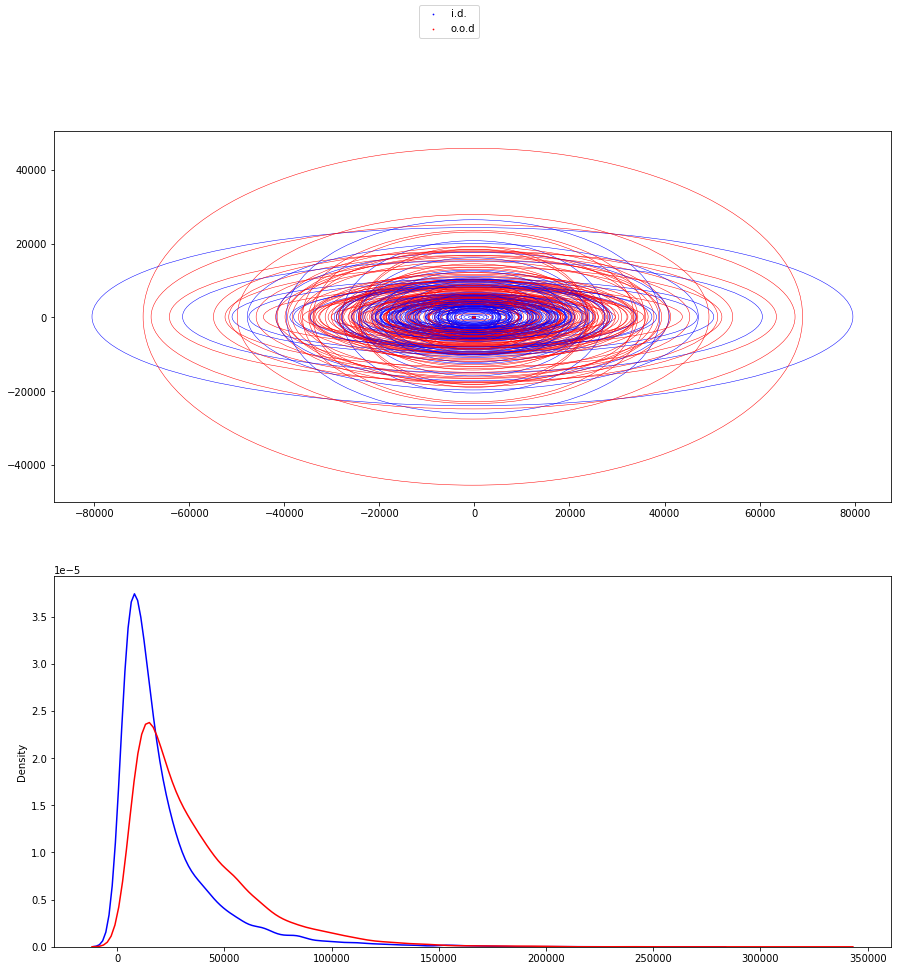

In [38]:
fig, axs = plt.subplots(2,1, figsize=(15,15))

## Plot scatter with uncertainty

axs[0].scatter(means_preds[:limit,0],means_preds[:limit,1], s=0.5, c="b", label="i.d.")
axs[0].scatter(means_preds_ood[:limit,0],means_preds_ood[:limit,1], s=0.5, c="r", label="o.o.d")

for i in range(limit):
    elp = Ellipse((means_preds[i,0],means_preds[i,1]), vars_preds[i,0], vars_preds[i,1], fc='None', edgecolor='b', lw=0.5)
    axs[0].add_patch(elp)
    elp = Ellipse((means_preds_ood[i,0],means_preds_ood[i,1]), vars_preds_ood[i,0], vars_preds_ood[i,1], fc='None', edgecolor='r', lw=0.5)
    axs[0].add_patch(elp)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

## Plot variance density
id_density = vars_preds.flatten()
sns.kdeplot(id_density, ax=axs[1], color="b")

ood_density = vars_preds_ood.flatten()
sns.kdeplot(ood_density, ax=axs[1], color="r")

plt.show()